In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn.functional as F

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
os.listdir("/kaggle/input/kdd-cup-1999-data")

['kddcup.data.gz',
 'kddcup.data',
 'kddcup.testdata.unlabeled',
 'training_attack_types',
 'kddcup.data.corrected',
 'kddcup.newtestdata_10_percent_unlabeled.gz',
 'corrected',
 'kddcup.testdata.unlabeled.gz',
 'kddcup.testdata.unlabeled_10_percent',
 'corrected.gz',
 'kddcup.newtestdata_10_percent_unlabeled',
 'kddcup.data_10_percent.gz',
 'kddcup.names',
 'kddcup.data_10_percent_corrected',
 'typo-correction.txt',
 'kddcup.data_10_percent',
 'kddcup.testdata.unlabeled_10_percent.gz']

In [3]:
!cat /kaggle/input/kdd-cup-1999-data/kddcup.names

back,buffer_overflow,ftp_write,guess_passwd,imap,ipsweep,land,loadmodule,multihop,neptune,nmap,normal,perl,phf,pod,portsweep,rootkit,satan,smurf,spy,teardrop,warezclient,warezmaster.
duration: continuous.
protocol_type: symbolic.
service: symbolic.
flag: symbolic.
src_bytes: continuous.
dst_bytes: continuous.
land: symbolic.
wrong_fragment: continuous.
urgent: continuous.
hot: continuous.
num_failed_logins: continuous.
logged_in: symbolic.
num_compromised: continuous.
root_shell: continuous.
su_attempted: continuous.
num_root: continuous.
num_file_creations: continuous.
num_shells: continuous.
num_access_files: continuous.
num_outbound_cmds: continuous.
is_host_login: symbolic.
is_guest_login: symbolic.
count: continuous.
srv_count: continuous.
serror_rate: continuous.
srv_serror_rate: continuous.
rerror_rate: continuous.
srv_rerror_rate: continuous.
same_srv_rate: continuous.
diff_srv_rate: continuous.
srv_diff_host_rate: continuous.
dst_host_count: continuous.
dst_host_srv_count: con

In [4]:
col_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 
             'dst_bytes','land', 'wrong_fragment', 'urgent', 'hot', 
             'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
             'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 
             'num_access_files', 'num_outbound_cmds', 'is_host_login', 
             'is_guest_login', 'count', 'srv_count', 'serror_rate', 
             'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 
             'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 
             'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 
             'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
             'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 
             'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 
             'dst_host_srv_rerror_rate', 'label']

In [5]:
df = pd.read_csv('/kaggle/input/kdd-cup-1999-data/kddcup.data.gz', names=col_names)

In [6]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


In [7]:
df.shape

(4898431, 42)

In [8]:
df.dtypes

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

In [9]:
df.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [10]:
df['label'].value_counts()

label
smurf.              2807886
neptune.            1072017
normal.              972781
satan.                15892
ipsweep.              12481
portsweep.            10413
nmap.                  2316
back.                  2203
warezclient.           1020
teardrop.               979
pod.                    264
guess_passwd.            53
buffer_overflow.         30
land.                    21
warezmaster.             20
imap.                    12
rootkit.                 10
loadmodule.               9
ftp_write.                8
multihop.                 7
phf.                      4
perl.                     3
spy.                      2
Name: count, dtype: int64

In [11]:
df['label'].nunique()

23

In [12]:
num_cols = df._get_numeric_data().columns

cate_cols = list(set(df.columns)-set(num_cols))

cate_cols

['flag', 'label', 'service', 'protocol_type']

In [13]:
df[cate_cols]

,flag,label,service,protocol_type
0,SF,normal.,http,tcp
1,SF,normal.,http,tcp
2,SF,normal.,http,tcp
3,SF,normal.,http,tcp
4,SF,normal.,http,tcp
...,...,...,...,...
4898426,SF,normal.,http,tcp
4898427,SF,normal.,http,tcp
4898428,SF,normal.,http,tcp
4898429,SF,normal.,http,tcp


In [14]:
# Make a copy of the initial dataframe so we can use different approach later
init_df = df.copy()

In [15]:
for category in cate_cols:
    print(df[category].value_counts())

flag
SF        3744328
S0         869829
REJ        268874
RSTR         8094
RSTO         5344
SH           1040
S1            532
S2            161
RSTOS0        122
OTH            57
S3             50
Name: count, dtype: int64
label
smurf.              2807886
neptune.            1072017
normal.              972781
satan.                15892
ipsweep.              12481
portsweep.            10413
nmap.                  2316
back.                  2203
warezclient.           1020
teardrop.               979
pod.                    264
guess_passwd.            53
buffer_overflow.         30
land.                    21
warezmaster.             20
imap.                    12
rootkit.                 10
loadmodule.               9
ftp_write.                8
multihop.                 7
phf.                      4
perl.                     3
spy.                      2
Name: count, dtype: int64
service
ecr_i        2811660
private      1100831
http          623091
smtp           96554
oth

In [16]:
category_mapping = {}
# Convert the non numerical values into numeric values via categorization e.g. TCP - 1, UDP -2 ...
for category in cate_cols:
    labels, unique_values = pd.factorize(df[category])
    df[category] = labels
    category_mapping[category] = dict(zip(set(unique_values), set(labels)))

df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,0,0,0,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0
1,0,0,0,0,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0
2,0,0,0,0,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,0
3,0,0,0,0,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,0
4,0,0,0,0,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0


In [17]:
category_mapping

{'flag': {'S2': 0,
  'S0': 1,
  'S1': 2,
  'RSTR': 3,
  'RSTOS0': 4,
  'RSTO': 5,
  'OTH': 6,
  'S3': 7,
  'SF': 8,
  'REJ': 9,
  'SH': 10},
 'label': {'phf.': 0,
  'pod.': 1,
  'spy.': 2,
  'multihop.': 3,
  'teardrop.': 4,
  'normal.': 5,
  'buffer_overflow.': 6,
  'guess_passwd.': 7,
  'perl.': 8,
  'portsweep.': 9,
  'back.': 10,
  'ipsweep.': 11,
  'nmap.': 12,
  'land.': 13,
  'ftp_write.': 14,
  'rootkit.': 15,
  'satan.': 16,
  'loadmodule.': 17,
  'warezclient.': 18,
  'smurf.': 19,
  'neptune.': 20,
  'imap.': 21,
  'warezmaster.': 22},
 'service': {'uucp': 0,
  'netbios_ssn': 1,
  'name': 2,
  'harvest': 3,
  'finger': 4,
  'mtp': 5,
  'pm_dump': 6,
  'auth': 7,
  'netstat': 8,
  'tim_i': 9,
  'tftp_u': 10,
  'nntp': 11,
  'exec': 12,
  'hostnames': 13,
  'urp_i': 14,
  'ftp_data': 15,
  'rje': 16,
  'Z39_50': 17,
  'time': 18,
  'ecr_i': 19,
  'ctf': 20,
  'login': 21,
  'echo': 22,
  'smtp': 23,
  'X11': 24,
  'shell': 25,
  'gopher': 26,
  'klogin': 27,
  'daytime': 28,
 

In [18]:
for category in cate_cols:
    print(df[category].value_counts())

flag
0     3744328
7      869829
5      268874
8        8094
6        5344
10       1040
2         532
1         161
9         122
4          57
3          50
Name: count, dtype: int64
label
5     2807886
4     1072017
0      972781
15      15892
10      12481
9       10413
17       2316
13       2203
20       1020
8         979
7         264
6          53
1          30
11         21
19         20
14         12
22         10
2           9
12          8
18          7
16          4
3           3
21          2
Name: count, dtype: int64
service
9     2811660
12    1100831
0      623091
1       96554
10      72653
       ...   
66          3
64          2
65          2
67          2
63          1
Name: count, Length: 70, dtype: int64
protocol_type
2    2833545
0    1870598
1     194288
Name: count, dtype: int64


<Axes: >

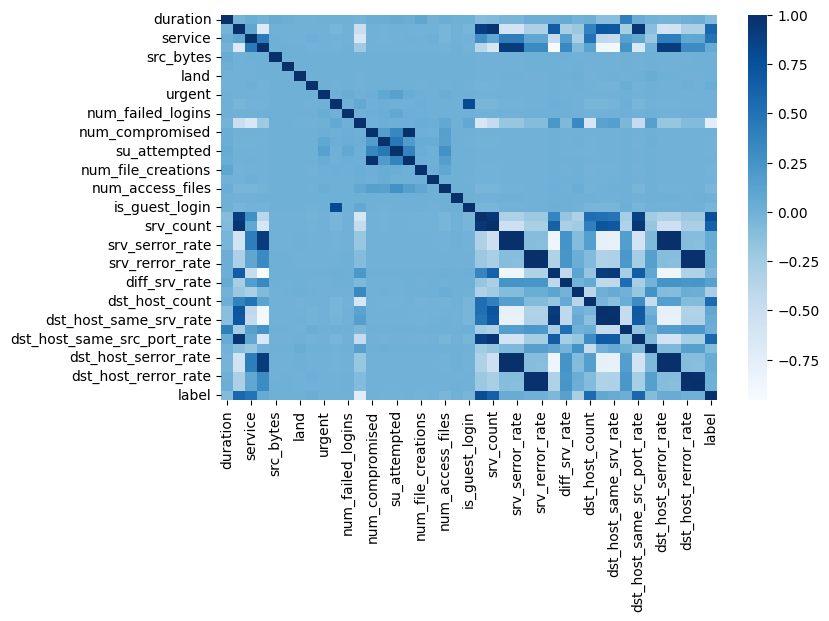

In [19]:
df = df[[col for col in df if df[col].nunique() > 1]]# keep columns where there are more than 1 unique values

corr = df.corr()

plt.figure(figsize=(8,5))
sns.heatmap(corr, cmap='Blues')

In [20]:
X = torch.tensor(df.drop('label',axis=1).values.astype(np.float32))
y = torch.tensor(df['label'].values, dtype=torch.long)
X,y

(tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0100, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0100, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0100, 0.0000, 0.0000]]),
 tensor([0, 0, 0,  ..., 0, 0, 0]))

In [21]:
# y = y.reshape(-1,1) #DO this for tensorflow or any other loss functions

In [22]:
y.size()

torch.Size([4898431])

In [23]:
X.shape

torch.Size([4898431, 40])

In [24]:
def pct_to_val(train_pct, data):
    '''Helper function to make code cleaer.
        changes percentage split into numbers of data.
        INPUTS:
        train_pct: the percentage of training data 
        valid_pct: the percentage of validation data
        data: the dataset
        returns: numbers of data'''
    train_num = int(train_pct/100*len(data))
    valid_num = int(len(data) - train_num)
    return train_num , valid_num

In [25]:
# OPT::::: 1 but cannot stratify with this strategy
# dataset = TensorDataset(X, y)
# train_num,valid_num = pct_to_val(75, dataset)
# Get traning and validation datasets.
# train_ds,valid_ds = random_split(dataset, [train_num, valid_num])

# OPT::::::2 ## stratify using train_test_split from sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33)
train_ds,valid_ds = TensorDataset(X_train, y_train), TensorDataset(X_test, y_test)
# Make a dataloader
BATCH = 1024
train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=BATCH, shuffle=True)

In [26]:
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(d, device) for d in data]
    return data.to(device, non_blocking=True)

In [27]:
class DeviceDL():
    
    def __init__(self, dl, dev):
        self.dl = dl
        self.dev = dev
    
    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.dev)
            
    def __len__(self):
        return len(self.dl)

In [28]:
train_dl = DeviceDL(train_dl, device)
valid_dl = DeviceDL(valid_dl, device)

In [29]:
def accuracy(label, preds):
    
    pred_labels = torch.argmax(preds, dim=1)
    # Check how many predictions match the ground truth labels
    correct_predictions = (pred_labels == label).sum() # Cast to int with .item()
    
    # Calculate accuracy
    accuracy = correct_predictions / len(pred_labels)
    return accuracy

In [30]:
class BaseNet(nn.Module):
    def get_loss(self, batch, loss_fn):
        features,labels = batch
        preds = self(features)
        loss = loss_fn(preds, labels)
        return loss
    
    def validate(self, batch, loss_fn):
        feature, labels = batch
        loss = self.get_loss(batch, loss_fn)
        pred = self(feature)
        
        acc = accuracy(labels, pred)
        return {'valid_loss' : loss , 'valid_acc' : acc}
    
    def average_validation(self, out):
        loss = torch.stack([l['valid_loss'] for l in out]).mean()
        acc = torch.stack([l['valid_acc'] for l in out]).mean()
        return {'valid_loss': loss.item() , 'valid_acc': acc.item()}
    
    def log_epoch(self, e, epoch, res):
        
        print('[{} / {}] epoch/s, training loss is {:.4f} validation loss is {:.4f}, validation accuracy is {:.4f} '\
              .format(e+1,epoch,
                      res['train_loss'],
                      res['valid_loss'],                
                      res['valid_acc']
                     )
             )

In [31]:
class ClassifierMLP(BaseNet):
    
    def __init__(self, activation, input_dim, hidden_1, hidden_2, hidden_3, out):
        super().__init__()
        self.hidden_1 = nn.Linear(input_dim, hidden_1)
        self.hidden_2 = nn.Linear(hidden_1, hidden_2)
        self.hidden_3 = nn.Linear(hidden_2, hidden_3)
        self.out = nn.Linear(hidden_3, out)
        self.activation = activation
        
    def forward(self, x):
        x1 = self.hidden_1(x)
        x2 = self.activation(x1)
        x3 = self.hidden_2(x2)
        x4 = self.activation(x3)
        x5 = self.hidden_3(x4)
        x6 = self.activation(x5)
        out = self.out(x6)
#         Note in pytorch we don't apply activation in final layer or use softmax because cross entropy
# loss function would do it automatically under the hood, we will rather only use softmax when interpreting
# the results in a human readable form. (not even while testing)
        return out
        
        

In [32]:
@torch.no_grad()
def valid(model, valid_dl, loss_fn):
    model.eval()
    out = [model.validate(batch, loss_fn) for batch in valid_dl]
    return model.average_validation(out)
    
def fit(model, train_dl, valid_dl, loss_fn, opt, EPOCHS):
    hist = []
    for e in range(EPOCHS):
        model.train()
        train_loss =[]
        for batch in train_dl:
            
            loss = model.get_loss(batch, loss_fn)
            train_loss.append(loss)
            loss.backward()
            opt.step()
            opt.zero_grad()
        
        res = valid(model, valid_dl, loss_fn)
        res['train_loss'] = torch.stack(train_loss).mean().item()
        
        model.log_epoch(e, EPOCHS, res)

        hist.append(res)
    return hist

In [33]:
torch.cuda.is_available()

True

In [34]:
activation = nn.ReLU()
input_dim = X.shape[1]
output_dim = df['label'].nunique()
hidden_1, hidden_2, hidden_3 = 256, 128, 128


model = ClassifierMLP(activation, input_dim, hidden_1, hidden_2, hidden_3, output_dim)
to_device(model, device)

ClassifierMLP(
  (hidden_1): Linear(in_features=40, out_features=256, bias=True)
  (hidden_2): Linear(in_features=256, out_features=128, bias=True)
  (hidden_3): Linear(in_features=128, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=23, bias=True)
  (activation): ReLU()
)

In [35]:
loss_fn = nn.CrossEntropyLoss()
lr = 0.000001
opt = torch.optim.Adam(model.parameters(), lr=lr)
EPOCHS = 20

In [36]:
history = fit(model, train_dl, valid_dl, loss_fn, opt, EPOCHS)

[1 / 20] epoch/s, training loss is 17.2959 validation loss is 8.3542, validation accuracy is 0.9400 
[2 / 20] epoch/s, training loss is 9.3185 validation loss is 2.2842, validation accuracy is 0.9719 
[3 / 20] epoch/s, training loss is 4.3659 validation loss is 0.2471, validation accuracy is 0.9871 
[4 / 20] epoch/s, training loss is 2.9796 validation loss is 0.1883, validation accuracy is 0.9908 
[5 / 20] epoch/s, training loss is 2.2048 validation loss is 0.3214, validation accuracy is 0.9867 
[6 / 20] epoch/s, training loss is 0.8539 validation loss is 0.2083, validation accuracy is 0.9913 
[7 / 20] epoch/s, training loss is 0.3074 validation loss is 0.0971, validation accuracy is 0.9907 
[8 / 20] epoch/s, training loss is 0.2103 validation loss is 0.1261, validation accuracy is 0.9918 
[9 / 20] epoch/s, training loss is 0.2418 validation loss is 0.3889, validation accuracy is 0.9848 
[10 / 20] epoch/s, training loss is 0.2703 validation loss is 0.4041, validation accuracy is 0.9883

In [37]:
history[0]

{'valid_loss': 8.354198455810547,
 'valid_acc': 0.9400408267974854,
 'train_loss': 17.295869827270508}

In [38]:
epochs = range(1,len(history)+1)
val_acc_values = [entry['valid_acc'] for entry in history]
test_loss_values = [entry['train_loss'] for entry in history]
val_loss_values = [entry['valid_loss'] for entry in history]

In [39]:
plt.style.use('ggplot')

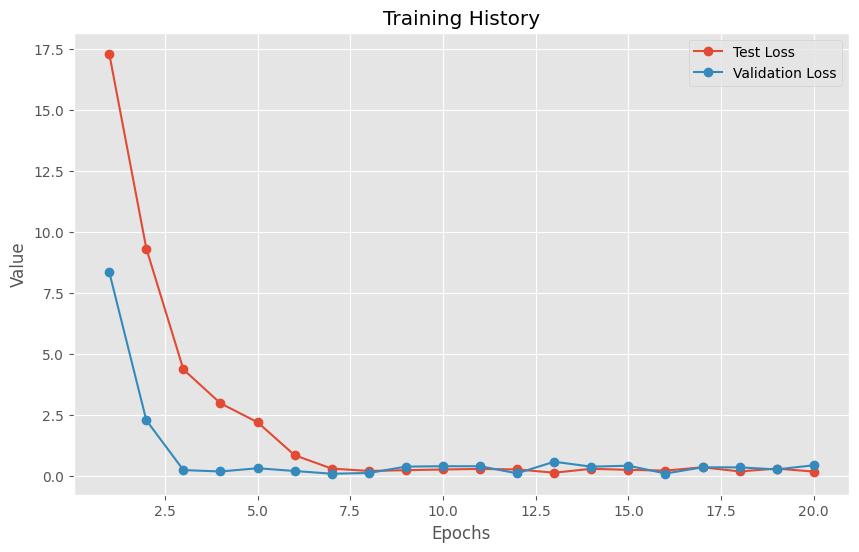

In [40]:

# Create a new figure
plt.figure(figsize=(10, 6))

# Plot validation accuracy
# plt.plot(epochs, val_acc_values, label='Validation Accuracy', marker='o', linestyle='-')
# Plot test loss
plt.plot(epochs, test_loss_values, label='Test Loss', marker='o', linestyle='-')
# Plot validation loss
plt.plot(epochs, val_loss_values, label='Validation Loss', marker='o', linestyle='-')

# Add labels and legend
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training History')
plt.legend()

# Show the plot
plt.grid(True)

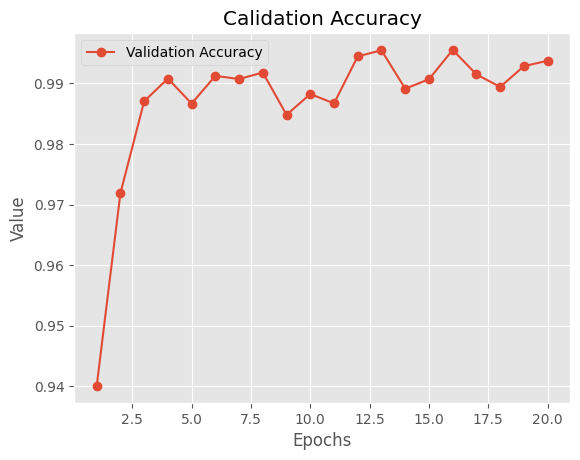

In [41]:
plt.plot(epochs, val_acc_values, label='Validation Accuracy', marker='o', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Calidation Accuracy')
plt.legend()

# Show the plot
plt.grid(True)

In [42]:
df_test = pd.read_csv("/kaggle/input/kdd-cup-1999-data/kddcup.testdata.unlabeled.gz", names=col_names.remove('label'))

In [43]:
df_test.head()

,0,udp,private,SF,105,146,0.1,0.2,0.3,0.4,...,1.2,1.3,1.00.1,0.00.6,1.00.2,0.00.7,0.00.8,0.00.9,0.00.10,0.00.11
0,0,udp,private,SF,105,146,0,0,0,0,...,255,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0
1,0,udp,private,SF,105,146,0,0,0,0,...,255,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0
2,0,udp,private,SF,105,146,0,0,0,0,...,255,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0
3,0,udp,private,SF,105,146,0,0,0,0,...,255,254,1.0,0.01,0.01,0.0,0.0,0.0,0.0,0.0
4,0,udp,private,SF,105,146,0,0,0,0,...,255,254,1.0,0.01,0.01,0.0,0.0,0.0,0.0,0.0


In [44]:
df.shape

(4898431, 41)